In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from plotting import ActivationPlotter
from pos_tagging import PosTagger
from data_handling import load_tinystories_data
from activation_extraction import ModelInspector, HookManager
from sae import SAE_topk
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

url = 'roneneldan/TinyStories-3M'
model = AutoModelForCausalLM.from_pretrained(url, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(url)

c:\Users\Bruger\Code\mechinterp\mechinterp\Lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [2]:
data = load_tinystories_data('../data/tinystories_val.txt')

In [3]:
input_size = model.config.hidden_size
device = 'cpu'
batch_size = 128

expansion_factor = 128

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 8,
    "pre_encoder_bias": False,
    "same_W": False
}


class SaeTrainer():
    def __init__(self, meta_data, learning_rate, device):
        self.input_size = input_size
        self.learning_rate = learning_rate

        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []


    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        hiddens = self.model.activations
        active_neurons = len(torch.unique(hiddens.indices))

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()


sae_trainer = SaeTrainer(meta_data, 0.001, 'cpu')

In [4]:
layers_pre_attn = []
layers_pre_mlp = []

with HookManager(model) as hook_manager:
    for layer in range(model.config.num_layers):
        layers_pre_attn.append(hook_manager.attach_residstream_hook(layer=layer, pre_mlp=False))
        layers_pre_mlp.append(hook_manager.attach_residstream_hook(layer=layer, pre_mlp=True)) 

    for story in data[:500]:
        tokenized = tokenizer(story, return_tensors='pt')
        model.forward(tokenized.input_ids)

all_resids = torch.concat([torch.concat(layer) for layer in layers_pre_attn + layers_pre_mlp])

layer_2_resids = torch.concat(layers_pre_attn[2])
ds = TensorDataset(layer_2_resids)
loader = DataLoader(ds, shuffle=True, batch_size=batch_size)


In [7]:
num_epochs = 5
for epoch_idx in range(num_epochs):
    for idx, batch in enumerate(loader):
        activation = batch[0].detach()
        label = activation.detach()

        loss, active_neurons = sae_trainer.train_step(activation, label)
        print(f'{epoch_idx}.{idx}\t\t{loss}\t\t{active_neurons}')


0.0		0.10693530738353729		174
0.1		0.10805965214967728		168
0.2		0.10170497000217438		171
0.3		0.0943879708647728		169
0.4		0.09955135732889175		164
0.5		0.09734390676021576		173
0.6		0.10582143068313599		168
0.7		0.10270504653453827		171
0.8		0.11086438596248627		175
0.9		0.09214182198047638		175
0.10		0.08455372601747513		186
0.11		0.09832173585891724		162
0.12		0.09401652961969376		184
0.13		0.09620385617017746		184
0.14		0.10088109970092773		168
0.15		0.10724906623363495		170
0.16		0.09331993758678436		175
0.17		0.11272786557674408		175
0.18		0.09596531838178635		173
0.19		0.09791334718465805		170
0.20		0.10391323268413544		179
0.21		0.09169533103704453		164
0.22		0.11199215054512024		159
0.23		0.07323172688484192		170
0.24		0.09161961823701859		168
0.25		0.09521402418613434		176
0.26		0.09606949239969254		176
0.27		0.10530620813369751		177
0.28		0.10368742048740387		178
0.29		0.1085238829255104		176
0.30		0.0867365300655365		169
0.31		0.09241408109664917		162
0.32		0.1222738176584

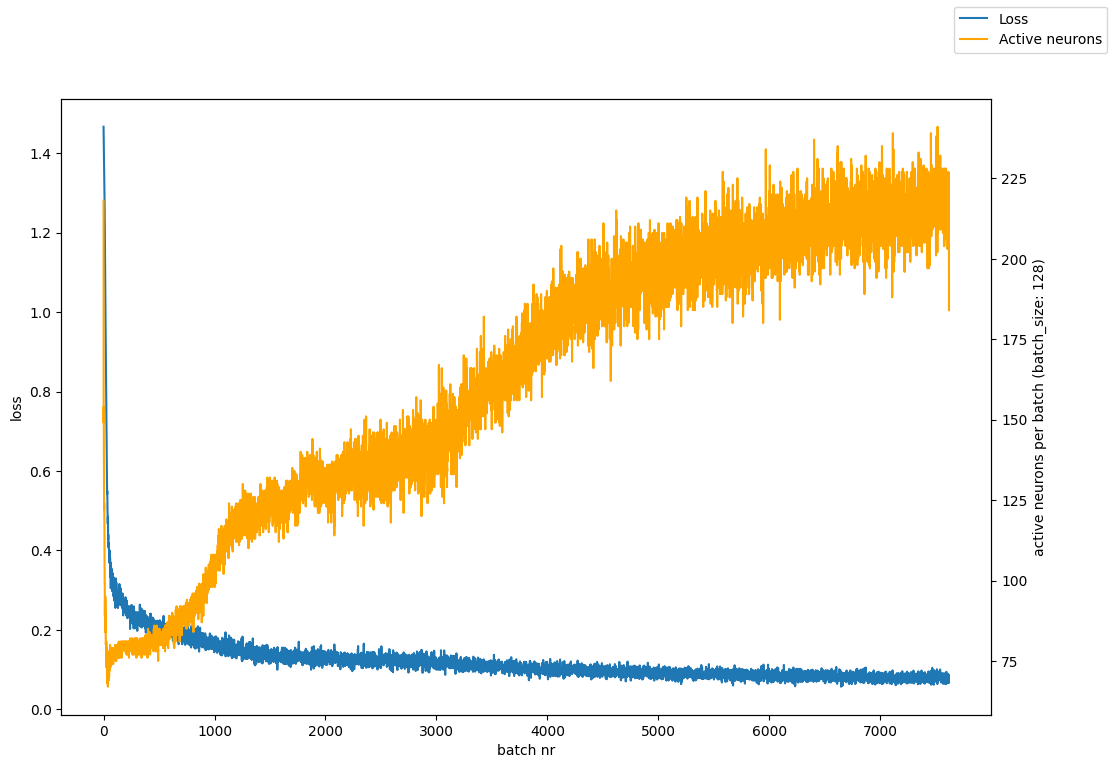

In [8]:
sae_trainer.plot_loss()

In [16]:
layers_pre_attn = []
layers_pre_mlp = []

with HookManager(model) as hook_manager:
    for layer in range(model.config.num_layers):
        layers_pre_attn.append(hook_manager.attach_residstream_hook(layer=layer, pre_mlp=False))
        layers_pre_mlp.append(hook_manager.attach_residstream_hook(layer=layer, pre_mlp=True)) 

    for story in data[100:101]:
        tokenized = tokenizer(story, return_tensors='pt')
        model.forward(tokenized.input_ids)

In [17]:
data[100]

"Once upon a time, there was a little girl named Lily. She loved to bake with her mom. One day, Lily wanted to make cookies all by herself. Her mom said she could try. Lily put all the ingredients in a bowl and stirred them together. She was so happy when she tasted the sweet dough. She put the cookies in the oven and waited for them to bake. But when the cookies were finished, they were burnt and hard. Lily was sad. She didn't have success with her cookies. Her mom hugged her and said it was okay. They would try again another day. "

In [19]:
inp = layers_pre_attn[2][0]
inp.shape

torch.Size([122, 128])

In [20]:
sae_trainer.model.get_activations(inp).indices

tensor([[15776, 15176,  8562,  ..., 14163, 14555,  3911],
        [15776,  9580,  8054,  ..., 15873, 10963, 12005],
        [15776, 12480,  8782,  ..., 14669,  4717, 13295],
        ...,
        [12232, 14610,  5692,  ...,  6108,  9330,  7138],
        [ 8782, 13310, 15776,  ..., 16082,  1662,  7214],
        [ 8782,  8546,  5336,  ...,  6608,   153,  6321]])

In [9]:
import datetime
import json
now = datetime.datetime.now()
now = now.__str__().replace(' ', '-').replace(':', '-')

newest_path = '../models/newest.pt'
meta_data_newest_path = '../models/newest.json'

model_out_path = f'../models/{now}.pt'
meta_data_out_path = f'../models/{now}.json'


torch.save(sae_trainer.model.state_dict(), model_out_path)
torch.save(sae_trainer.model.state_dict(), newest_path)

new_meta = {key: value for key, value in meta_data.items()}
new_meta['batch_size'] = batch_size
new_meta['num_batches_trained_on'] = sae_trainer.batches
new_meta['learning_rate'] = sae_trainer.learning_rate

with open(meta_data_out_path, 'w') as file:
        json.dump(new_meta, file, indent=4)
with open(meta_data_newest_path, 'w') as file:
        json.dump(new_meta, file, indent=4)